In [1]:
# Imports
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc

In [25]:
# Function to visualize confusion matrix

def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [3]:
df = pd.read_csv('savant_data.csv')

In [4]:
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [5]:
df = df[['game_date', 'batter', 'pitcher', 'events', 'description',
        'stand', 'p_throws', 'home_team', 'away_team',
        'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle']]

In [6]:
df.sort_values(by='estimated_ba_using_speedangle', ascending=False)[100:200]

,game_date,batter,pitcher,events,description,stand,p_throws,home_team,away_team,launch_speed,launch_angle,estimated_ba_using_speedangle
39837,2019-08-03,543068,518633,home_run,hit_into_play_score,R,L,MIN,KC,108.8,28.0,0.992
11000,2019-09-13,543807,641571,home_run,hit_into_play_score,R,R,KC,HOU,114.3,22.5,0.992
9859,2019-09-15,664056,502624,home_run,hit_into_play_score,R,R,STL,MIL,109.1,24.4,0.992
30153,2019-08-16,543510,621142,home_run,hit_into_play_score,R,R,LAA,CWS,109.3,28.3,0.992
20374,2019-08-31,596142,456701,home_run,hit_into_play_score,R,R,NYY,OAK,109.4,28.0,0.992
...,...,...,...,...,...,...,...,...,...,...,...,...
39125,2019-08-04,592885,506433,home_run,hit_into_play_score,L,R,CHC,MIL,106.6,24.6,0.982
17110,2019-09-04,606466,606131,home_run,hit_into_play_score,L,R,ARI,SD,109.4,21.7,0.982
5476,2019-09-21,543543,621295,home_run,hit_into_play_score,L,R,CLE,PHI,108.0,24.2,0.982
11047,2019-09-13,502671,519076,home_run,hit_into_play_score,R,R,STL,MIL,106.3,25.1,0.982


In [7]:
df['events'].unique()

array(['single', 'field_out', 'home_run', 'force_out', 'double',
       'grounded_into_double_play', 'double_play', 'sac_fly', 'triple',
       'fielders_choice_out', 'sac_bunt', 'fielders_choice',
       'sac_fly_double_play', 'sac_bunt_double_play', 'triple_play'],
      dtype=object)

In [8]:
df['description'].unique()

array(['hit_into_play_no_out', 'hit_into_play', 'hit_into_play_score'],
      dtype=object)

In [10]:
events = df['events'].to_list()
non_hits = ['single', 'home_run', 'double', 'triple']

hit = []
for i in events:
    if i in non_hits:
        x = 0
    else:
        x = 1
    hit.append(x)

In [12]:
df['hit'] = hit

In [14]:
df.columns

Index(['game_date', 'batter', 'pitcher', 'events', 'description', 'stand',
       'p_throws', 'home_team', 'away_team', 'launch_speed', 'launch_angle',
       'estimated_ba_using_speedangle', 'hit'],
      dtype='object')

In [16]:
df_final = df[['game_date', 'batter', 'pitcher', 'stand',
       'p_throws', 'home_team', 'away_team', 'launch_speed', 'launch_angle',
       'estimated_ba_using_speedangle', 'hit']]

In [19]:
# Subsetting target variable
target = df_final['hit']

# Preparing features
features = df_final.drop(['hit'], axis = 1, inplace = False)
# Dummy variables
features = pd.get_dummies(features)

In [21]:
# Testing/Trainging data split for model 

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

In [24]:
# Model
dt = DecisionTreeClassifier(random_state=10)  

# train
dt = dt.fit(X_train, y_train)

# predict
dt_train_preds = dt.predict(X_train)
dt_test_preds = dt.predict(X_test)

# evaluate
dt_train_accuracy = accuracy_score(y_train, dt_train_preds)
dt_test_accuracy = accuracy_score(y_test, dt_test_preds)
dt_test_precision = precision_score(y_test, dt_test_preds)
dt_test_F1 = f1_score(y_test, dt_test_preds)
dt_report = classification_report(y_test, dt_test_preds)

# append accuracy score to our dataframe
score_dt = ['Vanilla Decision Tree', dt_train_accuracy, dt_test_accuracy, dt_test_precision, dt_test_F1]

In [26]:
print('Classification Report Vanilla Decision Tree: \n', dt_report)
print('------------------------------------------------------')
print('')
print('Vanilla Decision Tree')
print('------------------------------------------------------')
print(f"Training Accuracy: {(dt_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(dt_test_accuracy * 100):.4}%")

Classification Report Vanilla Decision Tree: 
               precision    recall  f1-score   support

           0       0.60      0.61      0.61      3324
           1       0.81      0.80      0.80      6676

    accuracy                           0.74     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.74      0.74      0.74     10000

------------------------------------------------------

Vanilla Decision Tree
------------------------------------------------------
Training Accuracy: 100.0%
Test Accuracy:     73.81%


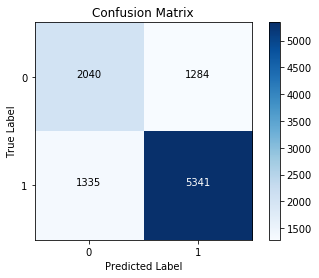

In [33]:
show_cf(y_test, dt_test_preds)

In [35]:
# model
rfc = RandomForestClassifier()

# train
rfc = rfc.fit(X_train, y_train)

# predict
rfc_train_preds = rfc.predict(X_train)
rfc_test_preds = rfc.predict(X_test)

# evaluate
rfc_train_accuracy = accuracy_score(y_train, rfc_train_preds)
rfc_test_accuracy = accuracy_score(y_test, rfc_test_preds)
rfc_test_precision = precision_score(y_test, rfc_test_preds)
rfc_test_F1 = f1_score(y_test, rfc_test_preds)
rfc_report = classification_report(y_test, rfc_test_preds)

# append accuracy score to our dataframe
score_rfc = ['Random Forest', rfc_train_accuracy, rfc_test_accuracy, rfc_test_precision, rfc_test_F1]

/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:

print('Classification Report Random Forest: \n', rfc_report)
print('------------------------------------------------------')
print('')
print('Random Forest')
print('------------------------------------------------------')
print(f"Training Accuracy: {(rfc_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(rfc_test_accuracy * 100):.4}%")

Classification Report Random Forest: 
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3324
           1       0.84      0.84      0.84      6676

    accuracy                           0.79     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.79      0.79      0.79     10000

------------------------------------------------------

Random Forest
------------------------------------------------------
Training Accuracy: 98.92%
Test Accuracy:     78.96%


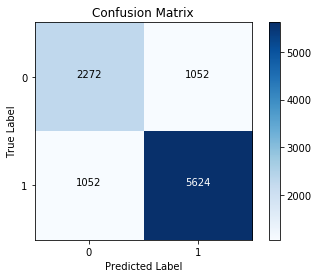

In [37]:
show_cf(y_test, rfc_test_preds)

In [38]:
import warnings
warnings.filterwarnings("ignore")
# model
adaboost = AdaBoostClassifier()

# train
adaboost = adaboost.fit(X_train, y_train)

# predict
adaboost_train_preds = adaboost.predict(X_train)
adaboost_test_preds = adaboost.predict(X_test)

# evaluate
adaboost_train_accuracy = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_accuracy = accuracy_score(y_test, adaboost_test_preds)
adaboost_test_precision = precision_score(y_test, adaboost_test_preds)
adaboost_test_F1 = f1_score(y_test, adaboost_test_preds)
adaboost_report = classification_report(y_test, adaboost_test_preds)

# append accuracy score to our dataframe
score_adaboost = ['Adaboost', adaboost_train_accuracy, adaboost_test_accuracy, adaboost_test_precision, adaboost_test_F1]

In [39]:
print('Classification Report Adaboost: \n', adaboost_report)
print('------------------------------------------------------')
print('')
print('Adaboost')
print('------------------------------------------------------')
print(f"Training Accuracy: {(adaboost_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(adaboost_test_accuracy * 100):.4}%")

Classification Report Adaboost: 
               precision    recall  f1-score   support

           0       0.70      0.73      0.71      3324
           1       0.86      0.84      0.85      6676

    accuracy                           0.80     10000
   macro avg       0.78      0.79      0.78     10000
weighted avg       0.81      0.80      0.81     10000

------------------------------------------------------

Adaboost
------------------------------------------------------
Training Accuracy: 80.79%
Test Accuracy:     80.49%


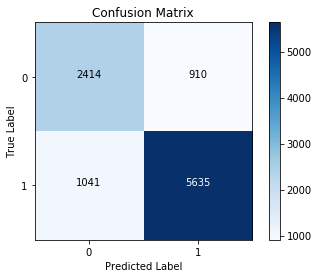

In [40]:
show_cf(y_test, adaboost_test_preds)